# 주요 내용
### training, validation, test data로 용어 통일
### 초기에 test data를 분리한 뒤, 모델 훈련 후 test data로 최종 검증
### tensorflow version을 2.1에서 2.2로 업데이트 (Colab 초기값)
### 모델에서 불필요층 제거 (Dense, Flatten) 및 새로운 층 추가 (GlobalMaxPooling1D)
### Epochs 50 → 100

In [0]:
import tensorflow as tf
tf.__version__

'2.2.0-rc1'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import os

pcm_path = "./pcm_dataset"
wav_path = "./wav_dataset"

# mkdir
if not os.path.exists(pcm_path):
    os.mkdir(pcm_path)

if not os.path.exists(wav_path):
    os.mkdir(wav_path)

# unzip with quite mode (-q options)
!unzip -q "/content/drive/My Drive/ETRI/9_voice_download_4_Korean_English_by_Korean_part2.zip" -d "./pcm_dataset"

print(os.listdir(pcm_path)[:5])
print(len(os.listdir(pcm_path)))

['I4F07852PKJ0', 'GSM06235BJH0', 'I4F02224SDY0', 'GSF06654KES0', 'GSF06934SYN0']
50


In [0]:
# pcm to wav

import wave

for i, folder_path in enumerate(os.listdir(pcm_path)):
    file_list = os.listdir(os.path.join(pcm_path, folder_path)) # label's path
    file_list_pcm = [files for files in file_list if files.endswith(".pcm")] # *.pcm files

    for j, file_path in enumerate(file_list_pcm):
        with open(os.path.join(pcm_path, folder_path, file_path), 'rb') as pcm_file:
            pcm_data = pcm_file.read()
        # save as {label}_{features}.wav format
        with wave.open(os.path.join(wav_path, '{}_{}.wav'.format(i, j)), 'wb') as wav_file:
            wav_file.setparams((1, 2, 16000, 0, 'NONE', 'NONE')) # 16kHz, mono channel
            wav_file.writeframes(pcm_data)

# print samples
print(os.listdir(wav_path)[:5])
print(len(os.listdir(wav_path)))

['14_68.wav', '6_39.wav', '7_22.wav', '14_0.wav', '48_67.wav']
5000


In [0]:
# initialized values

num_labels = 50
num_features = 100
sr = 16000
duration = 1

num_training_data = 80 # 100 * 0.2
num_test_data = num_features - num_training_data # i.e. 20

training_features = np.arange(0, num_training_data, 1) # 0 to 79
# no. of test data are fixed to evaluate fairly (as use always same test data)
test_features = np.arange(num_training_data, num_features, 1) # 80 to 99

# naming
save_training_data_name = 'training_data'
save_training_labels_name = 'training_labels'

save_test_data_name = 'test_data'
save_test_labels_name = 'test_labels'

In [0]:
# save features as *.npz format

import numpy as np
from scipy.io import wavfile

training_data = np.zeros((num_labels * num_training_data, duration * sr))
training_labels = np.zeros((num_labels * num_training_data))

test_data = np.zeros((num_labels * num_test_data, duration * sr))
test_labels = np.zeros((num_labels * num_test_data))

for i in range(num_labels):
    for j in range(num_features):
        file_name = "{}_{}.wav".format(i, j)
        sample_rate, samples = wavfile.read(os.path.join(wav_path, file_name))
        
        # extract 1 sec (i.e. 'duration * sr' length) of each files
        start = int(len(samples)//2 - duration * sample_rate / 2)
        end = int(len(samples)//2 + duration * sample_rate / 2)
        
        # save training data
        if j in training_features:
            training_data[i * num_training_data + j] = samples[start:end]
            training_labels[i * num_training_data + j] = i

        # save test data
        if j in test_features:
            test_data[i * num_test_data + (j - num_training_data)] = samples[start:end]
            test_labels[i * num_test_data + (j - num_training_data)] = i

# save *.npy        
np.save("./" + save_training_data_name, training_data)
np.save("./" + save_training_labels_name, training_labels)

np.save("./" + save_test_data_name, test_data)
np.save("./" + save_test_labels_name, test_labels)

In [0]:
# load data, labels

from tensorflow.keras.utils import to_categorical

training_data = np.load(save_training_data_name + ".npy")
training_labels = np.load(save_training_labels_name + ".npy")

print('training_data.shape: {}, training_labels.shape: {}'.format(training_data.shape, training_labels.shape))

training_data.shape: (4000, 16000), training_labels.shape: (4000,)


In [0]:
# split train & test data/labels

from sklearn.model_selection import train_test_split

random_state = 1234
len_data = training_data.shape[1] # i.e. sr * duration

X_train, X_val, Y_train, Y_val = train_test_split(training_data, training_labels,
                                                    test_size = 0.25, random_state = random_state)

x_train = X_train.reshape(len(X_train), len_data, 1)
x_val = X_val.reshape(len(X_val), len_data, 1) 

y_train = to_categorical(Y_train)
y_val = to_categorical(Y_val)

# standarization
mean = x_train.mean()
x_train -= mean
std = x_train.std()
x_train /= std

x_val -= mean
x_val /= std 

print('x_train.shape: {}, y_train.shape: {}'.format(x_train.shape, y_train.shape))
print('x_val.shape: {}, y_val.shape: {}'.format(x_val.shape, y_val.shape))

x_train.shape: (3000, 16000, 1), y_train.shape: (3000, 50)
x_val.shape: (1000, 16000, 1), y_val.shape: (1000, 50)


In [0]:
# generate model

from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(layers.Conv1D(16, 5, activation = 'relu', input_shape = (sr * duration, 1)))
model.add(layers.MaxPooling1D(5))

model.add(layers.Conv1D(32, 7, activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(5))

model.add(layers.Conv1D(64, 7, activation = 'relu'))
model.add(layers.MaxPooling1D(5))

model.add(layers.Conv1D(128, 7, activation = 'relu'))
model.add(layers.Conv1D(128, 8, activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.GlobalMaxPooling1D()) # add

# model.add(layers.Flatten())
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(num_labels, activation = 'softmax'))

model.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 15996, 16)         96        
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 3199, 16)          0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 3193, 32)          3616      
_________________________________________________________________
batch_normalization_6 (Batch (None, 3193, 32)          128       
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 638, 32)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 632, 64)           14400     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 126, 64)          

In [0]:
from datetime import datetime

batch_size = 80
epochs = 100

history = model.fit(x_train, y_train,
                    validation_data = (x_val, y_val),
                    epochs = epochs,
                    batch_size = batch_size,
                    verbose = 1)

save_model_path = "/content/drive/My Drive/models"
if not os.path.exists(save_model_path):
    os.mkdir(save_model_path)

model.save(os.path.join(save_model_path, "{}.h5".format(datetime.today().strftime("%Y_%m_%d"))))

Epoch 1/100
38/38 [==============================] - 3s 82ms/step - loss: 3.7640 - accuracy: 0.1293 - val_loss: 3.6731 - val_accuracy: 0.0900
Epoch 2/100
38/38 [==============================] - 3s 76ms/step - loss: 2.3123 - accuracy: 0.3517 - val_loss: 3.5707 - val_accuracy: 0.0650
Epoch 3/100
38/38 [==============================] - 3s 76ms/step - loss: 1.7057 - accuracy: 0.5130 - val_loss: 3.6803 - val_accuracy: 0.0730
Epoch 4/100
38/38 [==============================] - 3s 76ms/step - loss: 1.1748 - accuracy: 0.6540 - val_loss: 3.7395 - val_accuracy: 0.0840
Epoch 5/100
38/38 [==============================] - 3s 76ms/step - loss: 0.8383 - accuracy: 0.7530 - val_loss: 3.7315 - val_accuracy: 0.0680
Epoch 6/100
38/38 [==============================] - 3s 76ms/step - loss: 0.6286 - accuracy: 0.8110 - val_loss: 3.2032 - val_accuracy: 0.1510
Epoch 7/100
38/38 [==============================] - 3s 76ms/step - loss: 0.5056 - accuracy: 0.8403 - val_loss: 2.7947 - val_accuracy: 0.1920
Epoch 

In [0]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

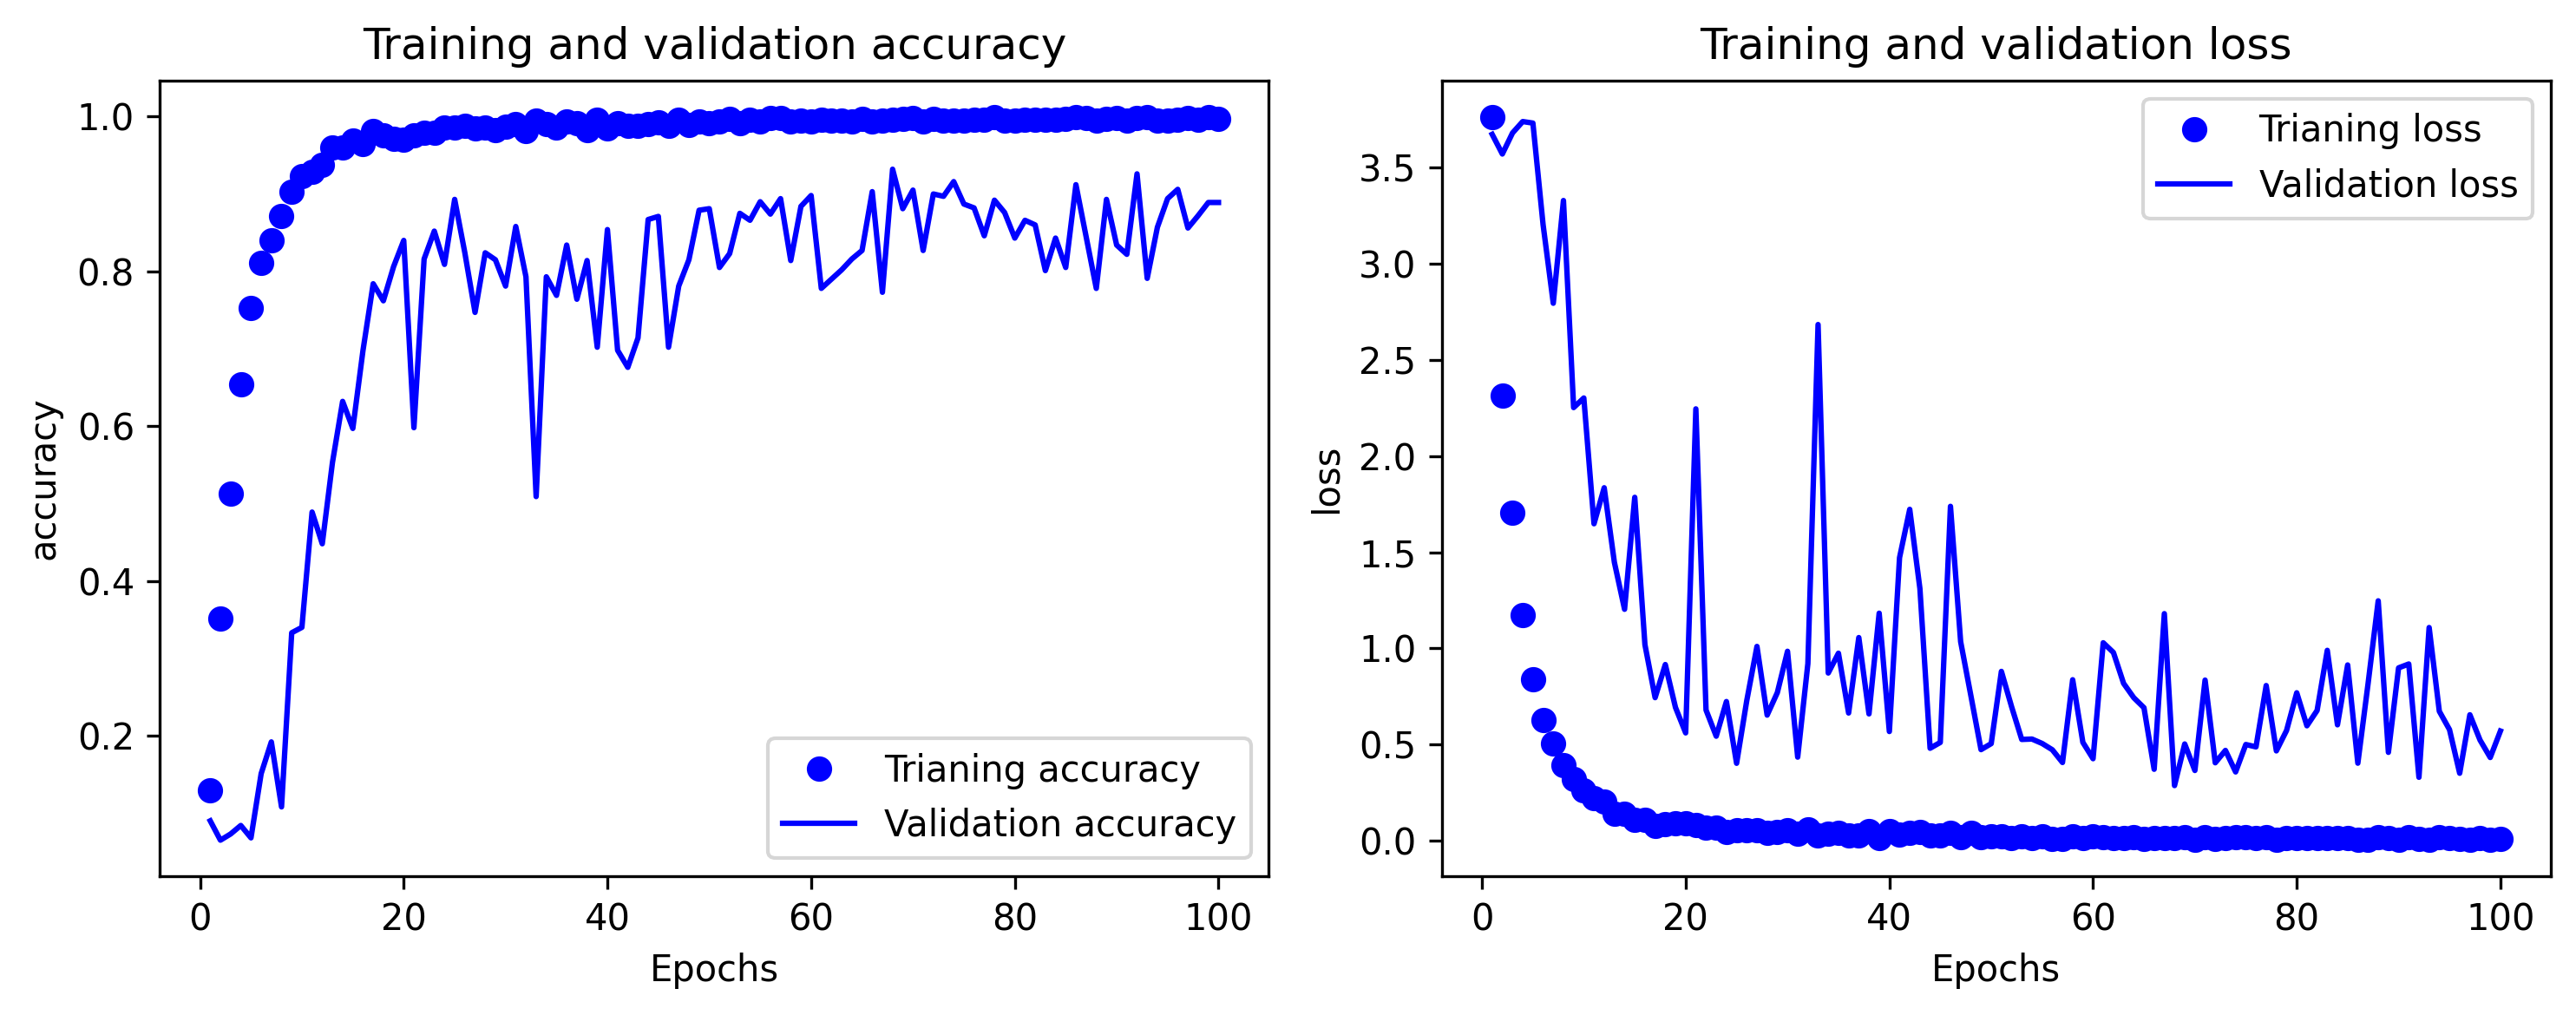

In [0]:
# plot

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure(figsize = (10, 4), facecolor = 'white', dpi = 300)

# accuracy
plt.subplot(1, 2, 1)

plt.plot(range(1, epochs + 1), acc, 'bo', label = 'Trianing accuracy')
plt.plot(range(1, epochs + 1), val_acc, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

# loss
plt.subplot(1, 2, 2)

plt.plot(range(1, epochs + 1), loss, 'bo', label = 'Trianing loss')
plt.plot(range(1, epochs + 1), val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

plt.tight_layout()
plt.show()

In [0]:
# evaluate as test data

test_data = np.load(save_test_data_name + ".npy")
test_labels = np.load(save_test_labels_name + ".npy")

# reshaping
test_data = test_data.reshape(len(test_data), len_data, 1)
test_labels = to_categorical(test_labels)

# standarization
test_data -= mean
test_data /= std 

print('test_data.shape: {}, test_labels.shape: {}'.format(test_data.shape, test_labels.shape))

test_data.shape: (1000, 16000, 1), test_labels.shape: (1000, 50)


In [0]:
# evaluate
results = model.evaluate(test_data, test_labels, batch_size = batch_size)

print('test loss, test acc:', results)

13/13 [==============================] - 0s 30ms/step - loss: 0.5688 - accuracy: 0.8780
test loss, test acc: [0.5688439011573792, 0.878000020980835]
